# GalfitM process

In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

In [37]:
img_name = 'nircam6'
prep_base = './io/prep/' + img_name + '/'
sample_base = './io/sample/' + img_name + '/'

## Prepare feedmes

In [3]:
from galfitclass import GalfitClass, SersicComponent

## Make Galfit Object with cutouts

customize calculate zeropoints

In [4]:
from utils.zeropoint import calc_zpt

In [38]:
pregalfit_path = prep_base + 'pregalfit.fits'
with fits.open(pregalfit_path) as hdul:
    hdul.info()
    tab_ini = Table(hdul['INIPARAM'].data)

Filename: ./io/prep/nircam6/pregalfit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  IMGLIST       1 BinTableHDU     13   7R x 2C   [5A, 70A]   
  2  INIPARAM      1 BinTableHDU     47   86R x 19C   [K, D, D, 22A, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D]   
  3  SEGMAP        1 ImageHDU         8   (10500, 4800)   int64   


### For single source

In [39]:
id = '12608'

In [40]:
band_labels = ['F115W','F150W','F200W','F277W','F356W','F410M','F444W']
band_wavelengths = [115.40, 150.00, 198.80, 276.10, 356.80, 408.20, 440.40]
psf_list = [f'../GalfitPy3/io/psf/{band.lower()}_psf.fits' for band in band_labels]
sample_dir = sample_base + id + '/'
print('Processing: ', id)

img_list = [sample_dir + 'sci_' + band + '.fits' for band in band_labels]
err_list = [sample_dir + 'err_' + band + '.fits' for band in band_labels]
bpmask_list = [sample_dir + 'bpmask_' + band + '.fits' for band in band_labels]

x_c = fits.getheader(img_list[0])['xc']
y_c = fits.getheader(img_list[0])['yc']
zpts = calc_zpt(x_c, y_c)

dict_band = dict(zip(band_labels, zip(band_wavelengths, zpts)))
# create a galfit object
gal_save_path = sample_dir + 'output.fits'
gal_obj = GalfitClass(dict_band, gal_save_path, plate_scale=(0.03,0.03))

gal_obj.load_data(img_list, err_list, bpmask_list)
gal_obj.load_psf(psf_list)
gal_obj.load_constraint('./constraint.txt')

# add a sersic component
sersic_comp = SersicComponent(gal_obj.nbands, skip=False)
sersic_comp.config_x(7, [gal_obj.image_size[0]/2+1]*7)
sersic_comp.config_y(7, [gal_obj.image_size[1]/2+1]*7)

row_ini = tab_ini[tab_ini['ID']==int(id)]
mag_ini_list = [row_ini[f'KronPhot_{band}_mag'][0] for band in band_labels]
sersic_comp.config_mag(7, mag_ini_list)
sersic_comp.config_n(2, [2.0]*2)
sersic_comp.config_re(2, [5.0]*2)
sersic_comp.config_q(1, [row_ini['eccentricity'][0]])
sersic_comp.config_pa(1, [row_ini['orientation'][0]])
    
gal_obj.add_component(sersic_comp)

# generate feedme file
feedme = gal_obj.genstr_feedme()
feedme_path = sample_dir + f'{id}.galfit'
with open(feedme_path, 'w') as f:
    f.write(feedme)

Processing:  12608
No correction dictionary name provided. Using default correction dictionary: CR. Automatically set verbose=True.
Using magnitude zeropoints for F150W from Boyer et al. (2022), and for the other six filters, we use the zero points from Brammer (2022).
SCI images loaded
ERR images loaded
Bad pixel masks loaded
PSF images loaded
Constraint file loaded


### Run GalfitM

In [42]:
feedme_path = sample_dir + f'12608.galfit'
gal_obj.run(feedme_path)


GALFITM Version galfitm-1.4.4
(based on GALFIT Version 3.0.5)


#  Input menu file: ./io/sample/nircam6/12608/12608.galfit

# IMAGE and GALFIT CONTROL PARAMETERS
A) ./io/sample/nircam6/12608/sci_F115W.fits,./io/sample/nircam6/12608/sci_F150W.fits,./io/sample/nircam6/12608/sci_F200W.fits,./io/sample/nircam6/12608/sci_F277W.fits,./io/sample/nircam6/12608/sci_F356W.fits,./io/sample/nircam6/12608/sci_F410M.fits,./io/sample/nircam6/12608/sci_F444W.fits      # Input data image (FITS file)
A1) F115W,F150W,F200W,F277W,F356W,F410M,F444W     # Band labels
A2) 115.400,150.000,198.800,276.100,356.800,408.200,440.400     # Band wavelengths
B) ./io/sample/nircam6/12608/output.fits      # Output data image block
C) ./io/sample/nircam6/12608/err_F115W.fits,./io/sample/nircam6/12608/err_F150W.fits,./io/sample/nircam6/12608/err_F200W.fits,./io/sample/nircam6/12608/err_F277W.fits,./io/sample/nircam6/12608/err_F356W.fits,./io/sample/nircam6/12608/err_F410M.fits,./io/sample/nircam6/12608/err_F444W.fits 0.

## Check GalfitM Result

In [28]:
sample_dir = './io/sample/nircam1/40997/'

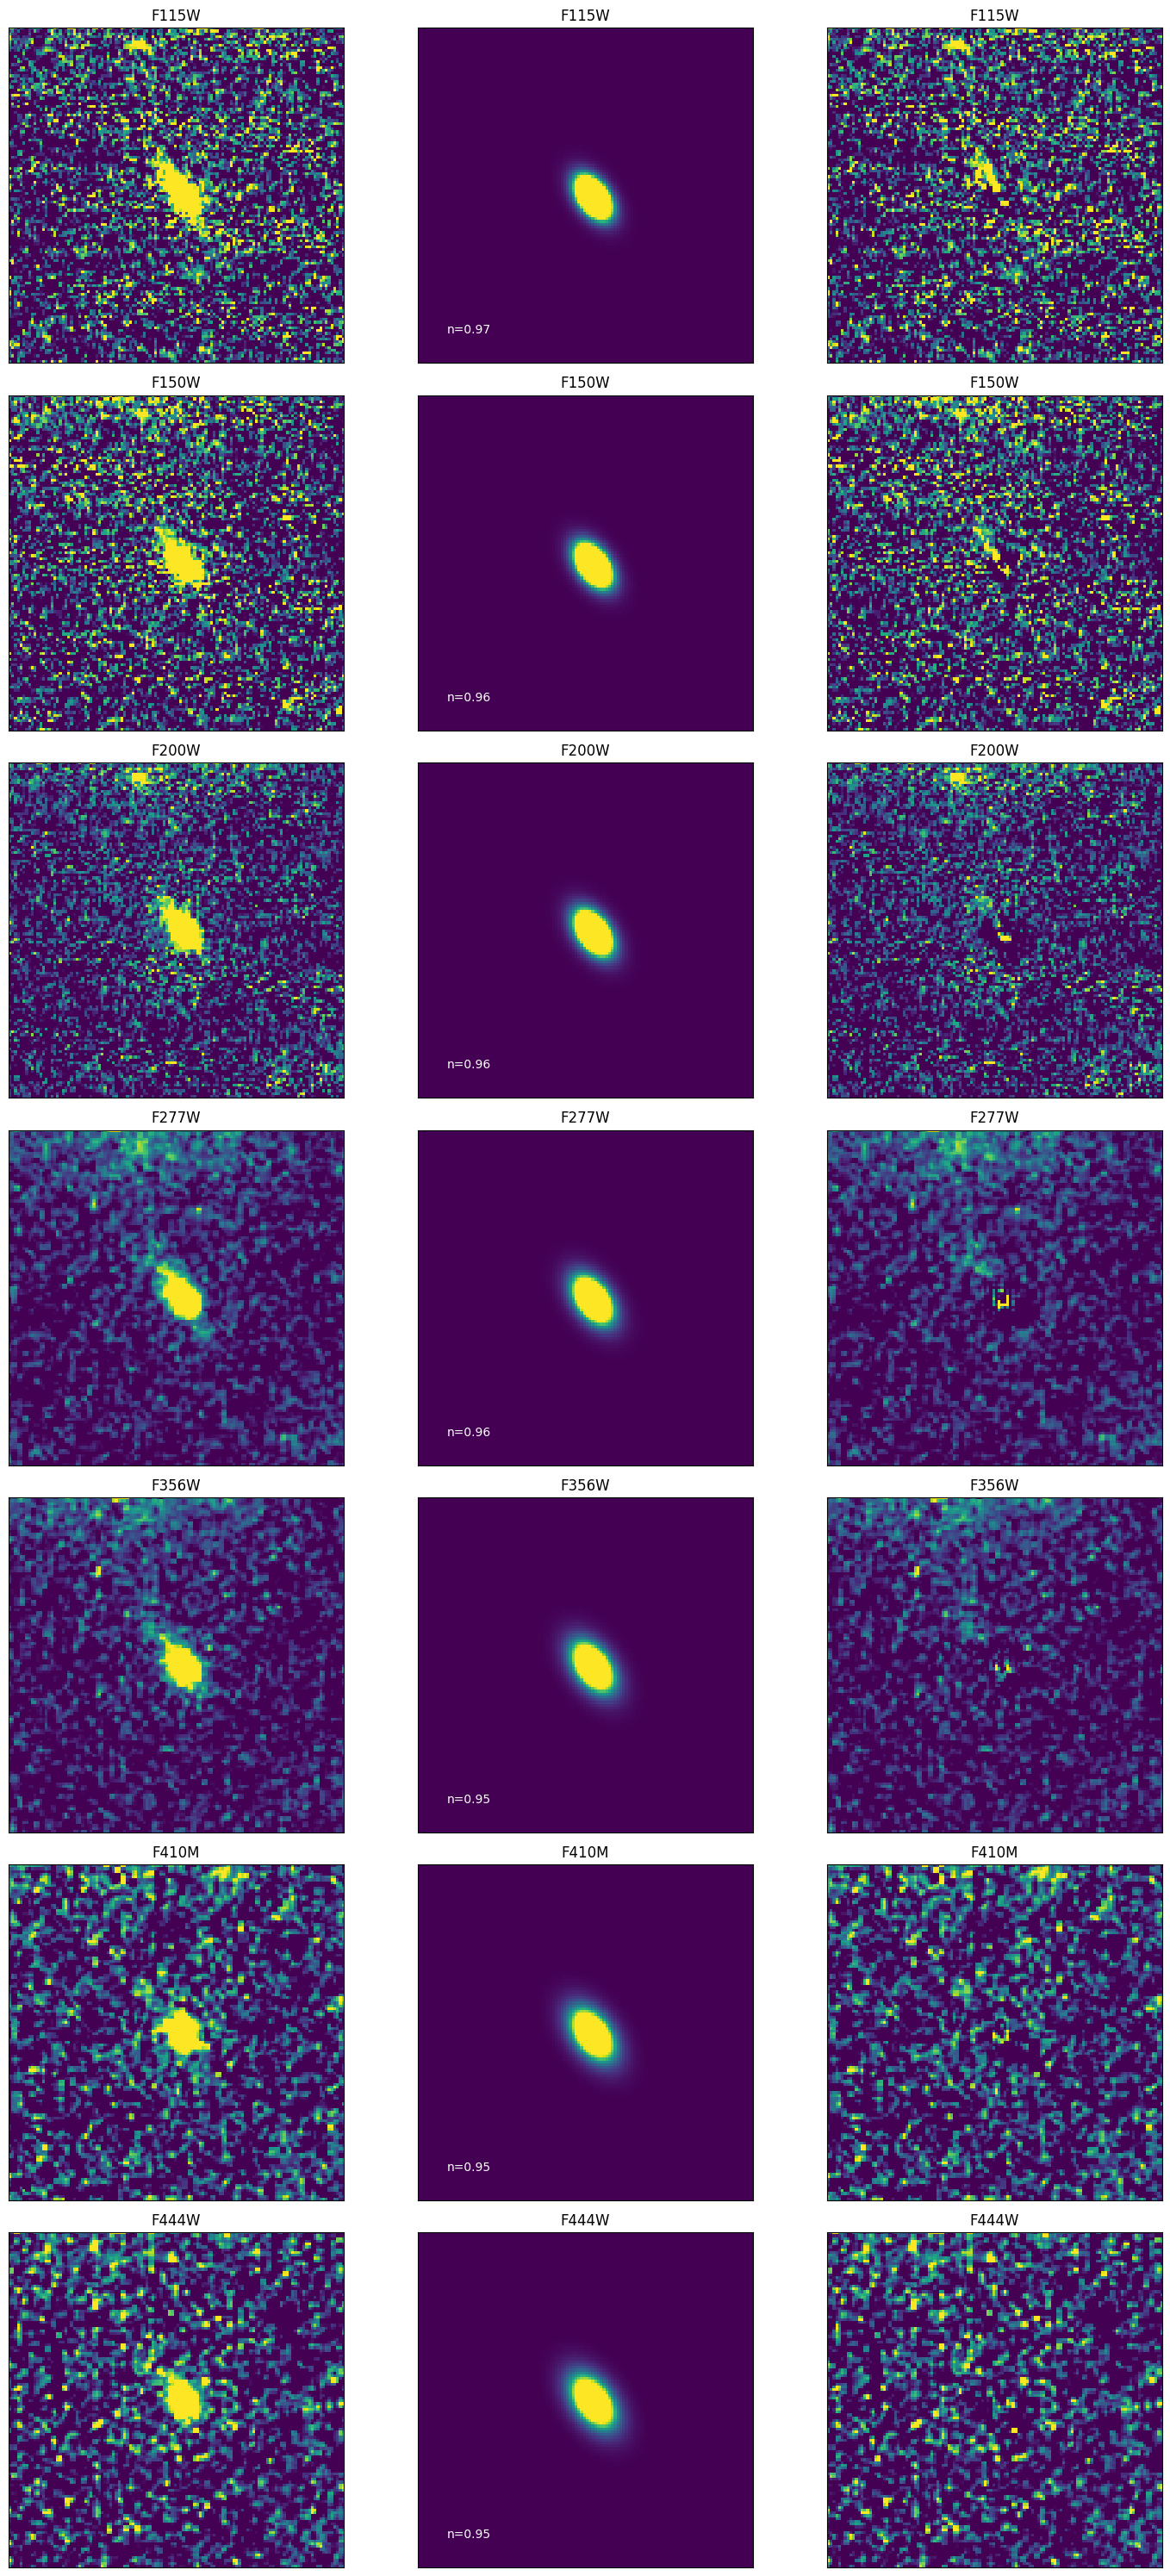

12608


In [43]:
fig, ax = plt.subplots(7,3,figsize=(15,30),sharex=True,sharey=True)
with fits.open(sample_dir + 'output.fits') as hdul:
    tab_finalband = Table(hdul[24].data)
    n_out = tab_finalband['COMP1_n']
    r_out = tab_finalband['COMP1_Re']
    for i in range(7):
        for j in [1,0,2]:
            ax_data = hdul[1+j*7+i].data
            if j==1:
                vmin = np.percentile(ax_data,90)
                vmax = np.percentile(ax_data,99)
                ax[i,j].text(10,10 ,f'n={n_out[i]:.2f}',color='w')
            ax[i,j].imshow(ax_data,origin='lower',vmin=vmin,vmax=vmax,cmap='viridis')
            ax[i,j].set_title(band_labels[i])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
plt.tight_layout()
plt.show()
print(sample_dir.split('/')[-2])

In [44]:
tab_finalband['COMP1_MAG']

25.92221
25.724539
25.613712
25.108545
25.358541
25.619837
25.650734
